In [1]:
import pandas as pd
import typing
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv('data/load_data/Electricity_Profile.csv', sep=",", header=None)
df = df.rename(columns={0: 'load'})
df['time'] = df.index%2400
freq_minutes = 1
n_rows = len(df)
date_col = pd.date_range(start='2023-01-01', periods=n_rows, freq=f'{freq_minutes}min')
df['datetime'] = date_col
df.set_index('datetime', inplace=True)
df

,load,time
datetime,,
2023-01-01 00:00:00,200,0
2023-01-01 00:01:00,200,1
2023-01-01 00:02:00,200,2
2023-01-01 00:03:00,91,3
2023-01-01 00:04:00,91,4
...,...,...
2023-04-10 23:55:00,91,2395
2023-04-10 23:56:00,91,2396
2023-04-10 23:57:00,91,2397


In [3]:
df = df.iloc[5:]

In [4]:
df = df.iloc[::30]
df

,load,time
datetime,,
2023-01-01 00:05:00,91,5
2023-01-01 00:35:00,91,35
2023-01-01 01:05:00,91,65
2023-01-01 01:35:00,91,95
2023-01-01 02:05:00,91,125
...,...,...
2023-04-10 21:35:00,361,2255
2023-04-10 22:05:00,2470,2285
2023-04-10 22:35:00,91,2315


In [5]:
# split the data into inputs and targets
freq = 30          # 1 point every 30 min
step = int(60/freq)    # number of points in an hour
past = 6*24*step    # will be using last 6 days of data
future = 1*24*step  # to predict next 1 day


# I want to use a T-days window of input data for predicting target_class
# It means I need to prepend (T-1) last train records to the 1st test window
T = past  # my choice of the timesteps window
pred_T = future
def create_batches(train_data, val_data, T, pred_T, feature_name):
    train_features, train_labels  = train_data.drop(feature_name,axis=1), train_data[[feature_name]]
    test_features, test_labels = val_data.drop(feature_name,axis=1), val_data[[feature_name]]

    prepend_features = train_features.iloc[-(T-1):]
    test_features = pd.concat([prepend_features, test_features], axis=0)

    print(train_features.shape, train_labels.shape, test_features.shape, test_labels.shape)


    # Create sequences of T timesteps (=sliding window)
    # Normalize sequences X = X/X_0-1, where X_0 is 1st timestep in the window:
    X_train, y_train = [], []
    for i in range(train_labels.shape[0] - (T+pred_T-1)):
        X_train.append(train_features.iloc[i:i+T])
        y_train.append(train_labels.iloc[i + (T-1):i + (T-1)+pred_T])
    X_train, y_train = np.array(X_train), np.array(y_train)
    print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')

    X_test, y_test = [], []
    for i in range(test_labels.shape[0]-pred_T):
        X_test.append(test_features.iloc[i:i+T])
        y_test.append(test_labels.iloc[i:i+pred_T])
    X_test, y_test = np.array(X_test), np.array(y_test)
    print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')
    y_train = y_train.reshape(-1,future)
    y_test = y_test.reshape(-1,future)

    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train = scaler_x.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    y_train = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape).reshape(-1,future)

    X_test= scaler_x.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    y_test= scaler_y.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape).reshape(-1,future)

    print(f'(after normalisation)  TEST data dimensions: {X_test.shape}, {y_test.shape}')
    print(f'(after normalisation)  Train data dimensions: {X_train.shape}, {y_train.shape}')

    return X_train, y_train, X_test, y_test, test_labels, scaler_x, scaler_y



800 (4800, 2)


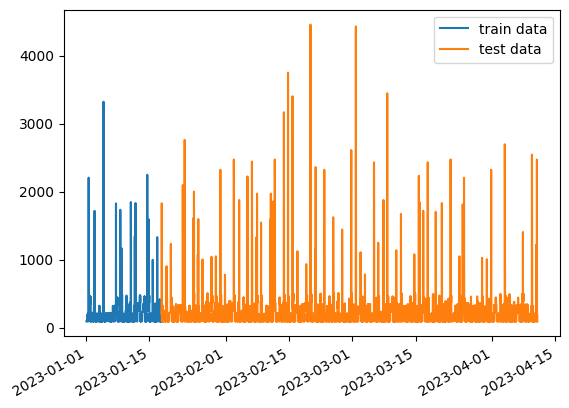

In [6]:
training_size = 800
print(training_size, df.shape)
train_data = df.iloc[:training_size]
val_data = df.iloc[training_size:]
plt.plot(train_data.index, train_data[['load']], label = 'train data')
plt.plot(val_data.index, val_data[['load']], label='test data')
plt.legend()
plt.gcf().autofmt_xdate()

In [50]:
val_data.iloc[0]

load    200
time      5
Name: 2023-01-17 16:05:00, dtype: int64

In [50]:
X_train, y_train, X_test, y_test, test_labels, scaler_x, scaler_y = create_batches(train_data, val_data, T, pred_T, 'load')
print(type(X_train), type(y_train))

(800, 1) (800, 1) (4287, 1) (4000, 1)
Train data dimensions: (465, 288, 1), (465, 48, 1)
Test data dimensions: (3952, 288, 1), (3952, 48, 1)
(after normalisation)  TEST data dimensions: (3952, 288, 1), (3952, 48)
(after normalisation)  Train data dimensions: (465, 288, 1), (465, 48)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [52]:
df_load_val_batches = {'X_test_batch': X_test, 'Y_test_batches': y_test, 'test_data_split': val_data, 'original filtered data': df, 'training_size': training_size, 'scaler_x':scaler_x, 'scaler_y': scaler_y}
type(df_load_val_batches)

dict

In [120]:
import json
from joblib import dump, load

In [55]:

dump(df_load_val_batches, 'data/cleaned_data/load_model_data.bin')

['data/cleaned_data/load_model_data.bin']

layers=[288, 96, 96, 48], train_examples=165, test_examples=452
batch = 256, timesteps = 288, features = 1, epochs = 120
lr = 0.001, lambda = 0.05, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 288, 288)          334080    
                                                                 
 lstm_10 (LSTM)              (None, 288, 96)           147840    
                                                                 
 lstm_11 (LSTM)              (None, 96)                74112     
                                                                 
 dense_3 (Dense)             (None, 48)                4656      
                                                                 
Total params: 560,688
Trainable params: 560,688
Non-trainable params: 0
______________________________________________________________

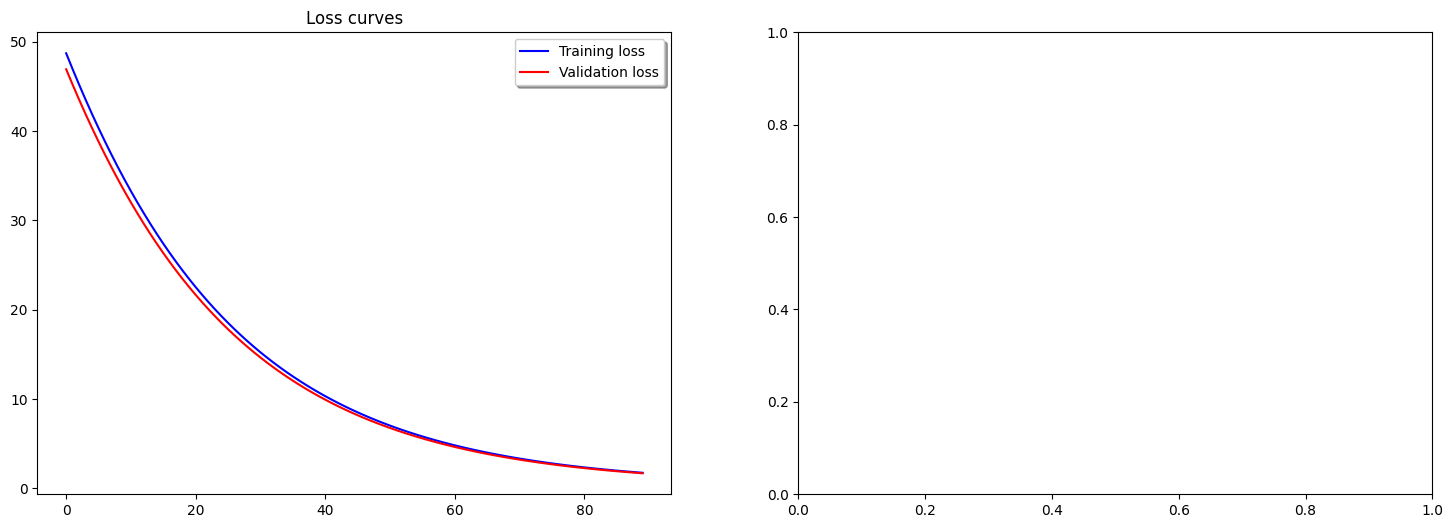

average load error: -0.734019085369268
 mse: 91810.36199715562


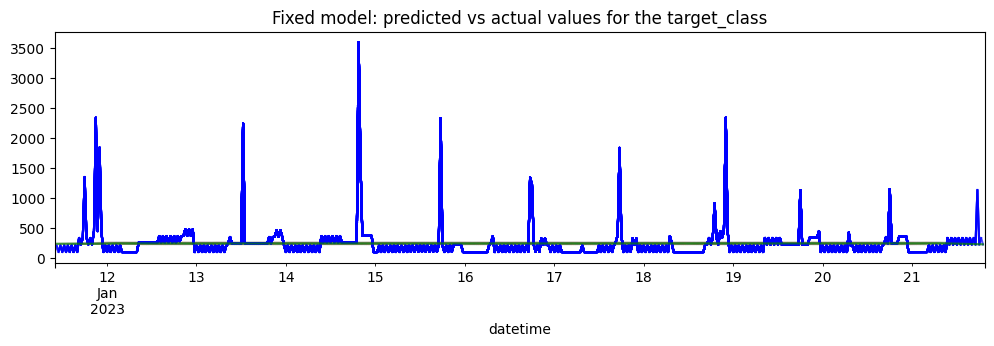

In [19]:
# Let's make a list of CONSTANTS for modelling:
LAYERS = [T, future*2, future*2, future]             # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = 1                                # number of features
BATCH = 256                          # batch size
EPOCH = 120                        # number of epochs
LR = 1e-3                            # learning rate of the gradient descent
LAMBD = 5e-2                         # lambda in L2 regularizaion
DP = 0.00                            # dropout rate
RDP = 0.00                           # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')

# Build the Model
# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T,N), units=LAYERS[0],
            activation='tanh', recurrent_activation='hard_sigmoid',
            kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            dropout=DP, recurrent_dropout=RDP,
            return_sequences=True, return_state=False,
            stateful=False, unroll=False))
model.add(LSTM(units=LAYERS[1],
            activation='tanh', recurrent_activation='hard_sigmoid',
            kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            dropout=DP, recurrent_dropout=RDP,
            return_sequences=True, return_state=False,
            stateful=False, unroll=False))
model.add(LSTM(units=LAYERS[2],
            activation='tanh', recurrent_activation='hard_sigmoid',
            kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            dropout=DP, recurrent_dropout=RDP,
            return_sequences=False, return_state=False,
            stateful=False, unroll=False))
model.add(Dense(units=LAYERS[3], activation='relu'))

# Compile the model with Adam optimizer
model.compile(loss='mae', metrics=['accuracy'],
            optimizer=Adam(learning_rate=LR))
print(model.summary())



# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', patience=1, verbose=0, 
                            factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                           patience=90, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=False)

History = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH,
                    validation_split=0.2, shuffle=True,verbose=0, callbacks=[lr_decay, early_stop])
# Evaluate the model:
train_acc = History.history['accuracy'][-1]    #model.evaluate(X_train, y_train, batch_size=M_TRAIN)
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=M_TEST)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 2)}%')
print(f'fixed model test score = {round(test_acc * 100, 2)}%')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
plt.show()


## for large amount
fixed_predict = model.predict_on_batch(X_test)
j = 0
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('Fixed model: predicted vs actual values for the target_class')
dff_avg = pd.DataFrame({'predicted':  np.full(test_labels.shape[0], np.nan)},index=test_labels.index)
avg_temperr=0
avg_mse=0
for i in range(fixed_predict.shape[0]):

    averaged = scaler_y.inverse_transform(fixed_predict)[i]
    # Plot predictions vs actual labels for fixed model
    actual = scaler_y.inverse_transform(y_test)[i]

    # averaged = fixed_predict[i]*1000
    # actual  = y_test[i]*1000
    index = test_labels.iloc[i:i+actual.shape[0]].index

    # print(fixed_predict)
    dff1 = pd.DataFrame({f'predicted': averaged.squeeze()}, index=index)
  
    # Assuming dff1 and dff2 are two dataframes with different index lengths
    # Join the two dataframes on their index
    dff_avg = dff_avg.join(dff1, how='left', rsuffix=f'_{i}')
    dff2 = pd.DataFrame({'actual': actual.squeeze()}, index=index)
    dff1.plot(ax=ax, alpha=0.1, legend=False)
    dff2.plot(ax=ax, alpha=0.7, color='blue', legend=False)
    avg_temperr +=np.mean(dff1['predicted']-dff2['actual'])
    avg_mse +=mean_squared_error(dff1['predicted'], dff2['actual'])
dff_avg= dff_avg.mean(axis=1)
dff_avg.plot(ax=ax, alpha=0.7, color='green', legend=False)
print(f"average load error: {avg_temperr/fixed_predict.shape[0]}")
print(f" mse: {avg_mse/fixed_predict.shape[0]}")
plt.show()

d:\mukul\anaconda3\envs\SOML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(452, 48)
(500,)
average cum solar error: -0.734019085369268
 cum mse: 91810.36199715562
mean temp error:  -5.252439189249355 mse:  94193.30447663726


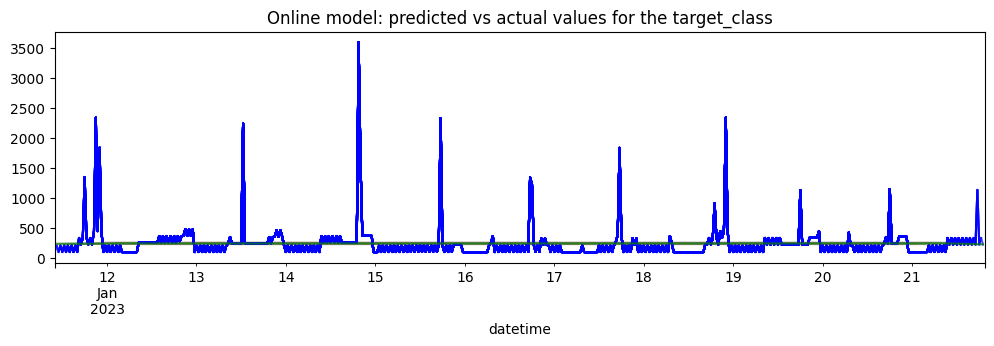

In [20]:

config, weights = model.get_config(), model.get_weights()
online_model = Sequential.from_config(config)
online_model.set_weights(weights)
online_model.compile(loss='mse', optimizer=Adam(lr=LR))


# Online training (update model with each new data available):
predictions = []

online_len = y_test.shape[0]
for t in range(online_len):
    x = X_test[t].reshape(-1,T,N)  # a "new" input is available
    y_hat = online_model.predict_on_batch(x) # predict on the "new" input
    # averaged = np.mean(y_hat[:,3:6,:], axis=1)
    predictions.append(y_hat)  # save predictions
    y = y_test[t].reshape(1,-1,1)   # a "new" label is available
    online_model.train_on_batch(x, y)  # runs a single gradient update 


## for large amount
fixed_predict = np.array(predictions)
fixed_predict = fixed_predict.reshape(fixed_predict.shape[0],-1)
print(fixed_predict.shape)
j = 0
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('Online model: predicted vs actual values for the target_class')
dff_avg = pd.DataFrame({'predicted':  np.full(test_labels.shape[0], np.nan)},index=test_labels.index)
dff_actual = pd.DataFrame({'actual':  np.array(test_labels).reshape(-1)},index=test_labels.index)
avg_temperr=0
avg_mse=0
j=0
for i in range(online_len):
    # averaged = fixed_predict[i]*1000
    # actual = y_test[i]*1000
    
    averaged = scaler_y.inverse_transform(fixed_predict)[i]
    # Plot predictions vs actual labels for fixed model
    actual = scaler_y.inverse_transform(y_test)[i]
    index = test_labels.iloc[i:i+actual.shape[0]].index

    # print(fixed_predict)
    dff1 = pd.DataFrame({'predicted': averaged.squeeze()}, index=index)
    j+=1
    # Assuming dff1 and dff2 are two dataframes with different index lengths
    # Join the two dataframes on their index
    dff_avg = dff_avg.join(dff1, how='left', rsuffix=f'_{i}')
    dff2 = pd.DataFrame({'actual': actual.squeeze()}, index=index)
    dff1.plot(ax=ax, alpha=0.1, legend=False)
    dff2.plot(ax=ax, alpha=0.7, color='blue', legend=False)
    avg_temperr +=np.mean(dff1['predicted']-dff2['actual'])
    avg_mse +=mean_squared_error(dff1['predicted'], dff2['actual'])
dff_avg= dff_avg.mean(axis=1)
print(dff_avg.values.shape)
dff_avg.plot(ax=ax, alpha=0.7, color='green')
print(f"average cum solar error: {avg_temperr/fixed_predict.shape[0]}")
print(f" cum mse: {avg_mse/fixed_predict.shape[0]}")

dff_avg_arry = np.array(dff_avg.values).reshape(-1)
dff_actual_arry = np.array(dff_actual['actual']).reshape(-1)[~np.isnan(dff_avg_arry)]
dff_avg_arry = dff_avg_arry[~np.isnan(dff_avg_arry)]
diff = (dff_avg_arry-dff_actual_arry)
dff_mse = mean_squared_error(dff_avg_arry, dff_actual_arry)
print("mean temp error: ", np.mean(diff), "mse: ", dff_mse)
plt.show()


conv network

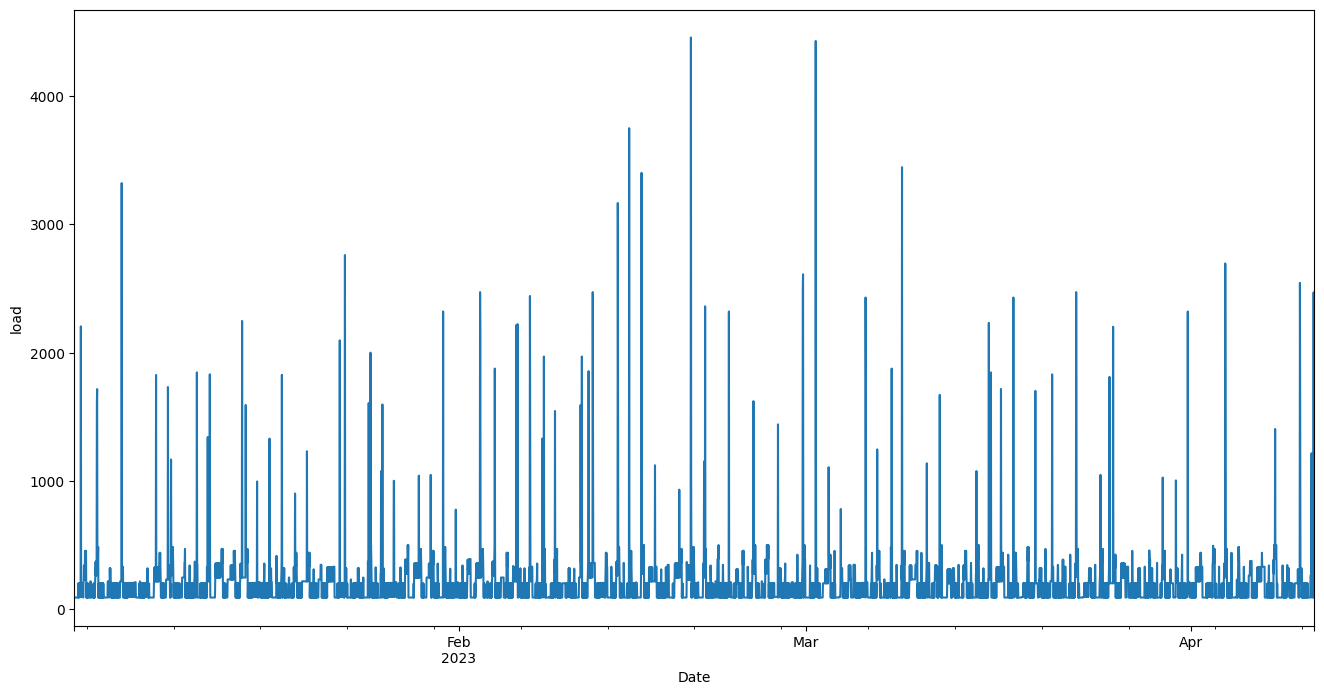

In [51]:
plt.figure(figsize=(16,8))
df['load'].plot()
plt.xlabel('Date')
plt.ylabel('load')
plt.show()

In [84]:
df_1=df['load'].values.reshape(-1,1)/1000
df_1=df_1.astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4800 entries, 2023-01-01 00:05:00 to 2023-04-10 23:35:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   load    4800 non-null   int64
 1   time    4800 non-null   int64
dtypes: int64(2)
memory usage: 112.5 KB


In [85]:
scaler = StandardScaler()
ts = scaler.fit_transform(df_1)

In [86]:
timestep = 128
X= []
Y=[]

raw_data=ts

for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 800
Xtrain = X[:k,:,:]  
Ytrain = Y[:k]  

In [87]:
Xtrain

array([[[-0.45139867],
        [-0.45139867],
        [-0.45139867],
        ...,
        [-0.45139867],
        [-0.45139867],
        [-0.45139867]],

       [[-0.45139867],
        [-0.45139867],
        [-0.45139867],
        ...,
        [-0.45139867],
        [-0.45139867],
        [-0.45139867]],

       [[-0.45139867],
        [-0.45139867],
        [-0.45139867],
        ...,
        [-0.45139867],
        [-0.45139867],
        [ 0.0145644 ]],

       ...,

       [[-0.45139867],
        [-0.0483036 ],
        [-0.45139867],
        ...,
        [-0.0483036 ],
        [-0.45139867],
        [-0.0483036 ]],

       [[-0.0483036 ],
        [-0.45139867],
        [-0.0483036 ],
        ...,
        [-0.45139867],
        [-0.0483036 ],
        [-0.45139867]],

       [[-0.45139867],
        [-0.0483036 ],
        [ 0.1809798 ],
        ...,
        [-0.0483036 ],
        [-0.45139867],
        [ 0.36218765]]], dtype=float32)

In [10]:
from keras.models import Sequential
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [88]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(timestep, 1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
print(model.summary())
# fit model
history = model.fit(Xtrain, Ytrain, epochs=200, verbose=0)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 127, 128)          384       
                                                                 
 conv1d_7 (Conv1D)           (None, 126, 128)          32896     
                                                                 
 conv1d_8 (Conv1D)           (None, 125, 128)          32896     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 62, 128)          0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 7936)              0         
                                                                 
 dense_4 (Dense)             (None, 100)               793700    
                                                      

In [129]:
import os
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '0'


In [131]:
tf.keras.models.save_model(model, "saved_model/load_cnn.h5")

In [89]:
Xtest = X[k:,:,:]  
Ytest= Y[k:]  

In [113]:
def clean_load_pred(arr):
    arr = np.where((arr >= 0.4) & (arr <= 0.8), 0.1, arr)
    arr = np.clip(arr, 0.091, np.inf)
    return arr

121/121 [==============================] - 2s 16ms/step


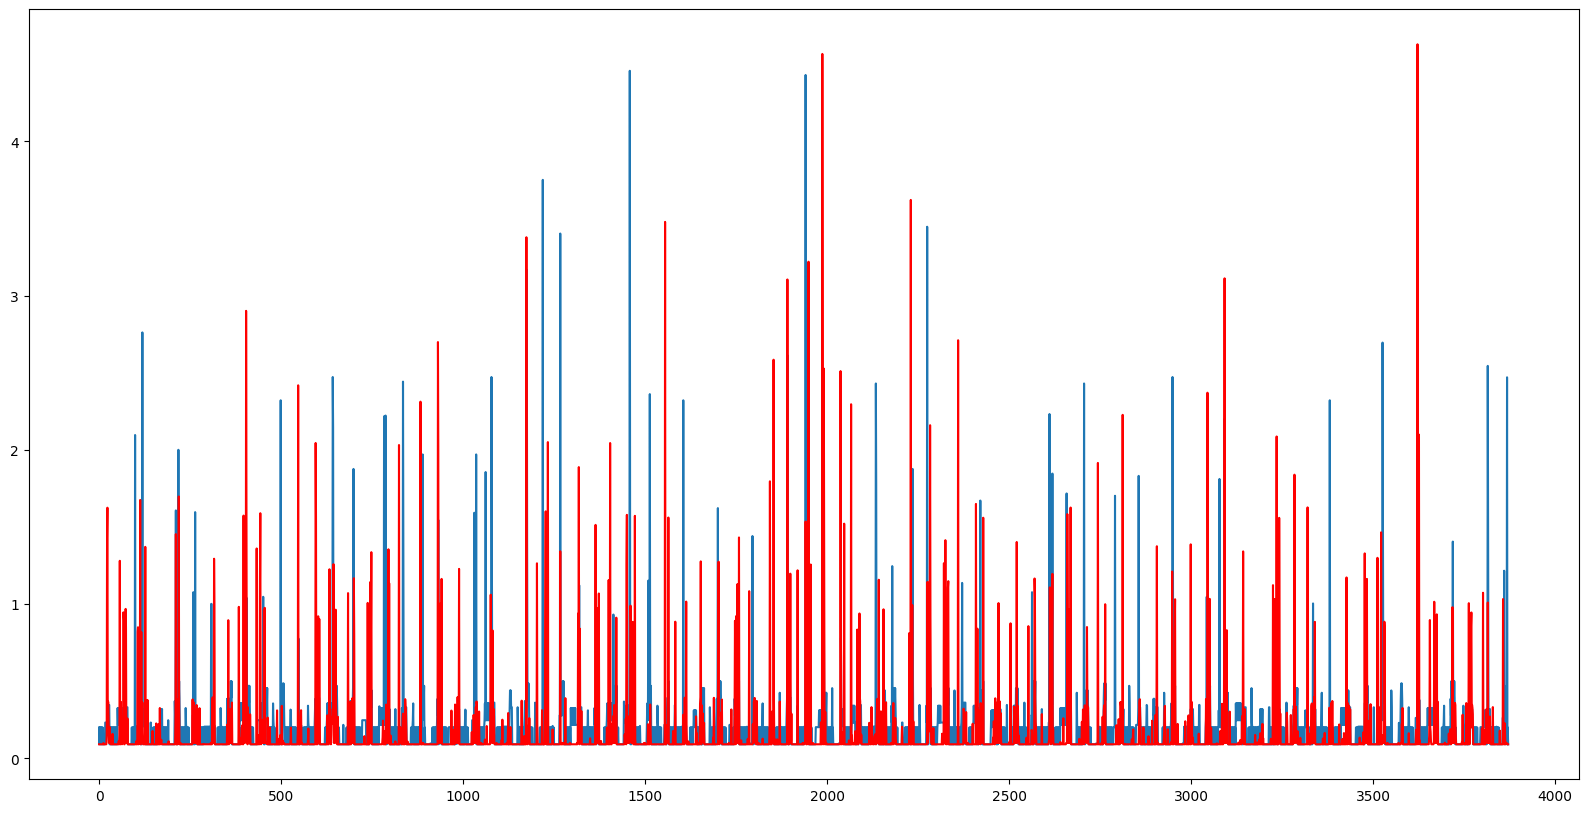

In [116]:
preds1 = model.predict(Xtest)
preds1 = clean_load_pred(preds1)


Ytest1=np.asanyarray(Ytest)  
Ytest1=Ytest1.reshape(-1,1) 
Ytest1 = scaler.inverse_transform(Ytest1)


Ytrain1=np.asanyarray(Ytrain)  
Ytrain1=Ytrain1.reshape(-1,1) 
Ytrain1 = scaler.inverse_transform(Ytrain1)

mean_squared_error(Ytest1,preds1)
plt.figure(figsize=(20,10))
plt.plot(Ytest1)
plt.plot(preds1, 'r')
plt.show()

In [117]:
def plot_pred(model, Xtest, Ytest):
    preds1 = model.predict(Xtest)
    preds1 = clean_load_pred(preds1)


    Ytest1=np.asanyarray(Ytest)  
    Ytest1=Ytest1.reshape(-1,1) 
    Ytest1 = scaler.inverse_transform(Ytest1)


    mean_squared_error(Ytest1,preds1)
    plt.figure(figsize=(20,10))
    plt.plot(Ytest1)
    plt.plot(preds1, 'r')
    plt.show()

2/2 [==============================] - 0s 43ms/step


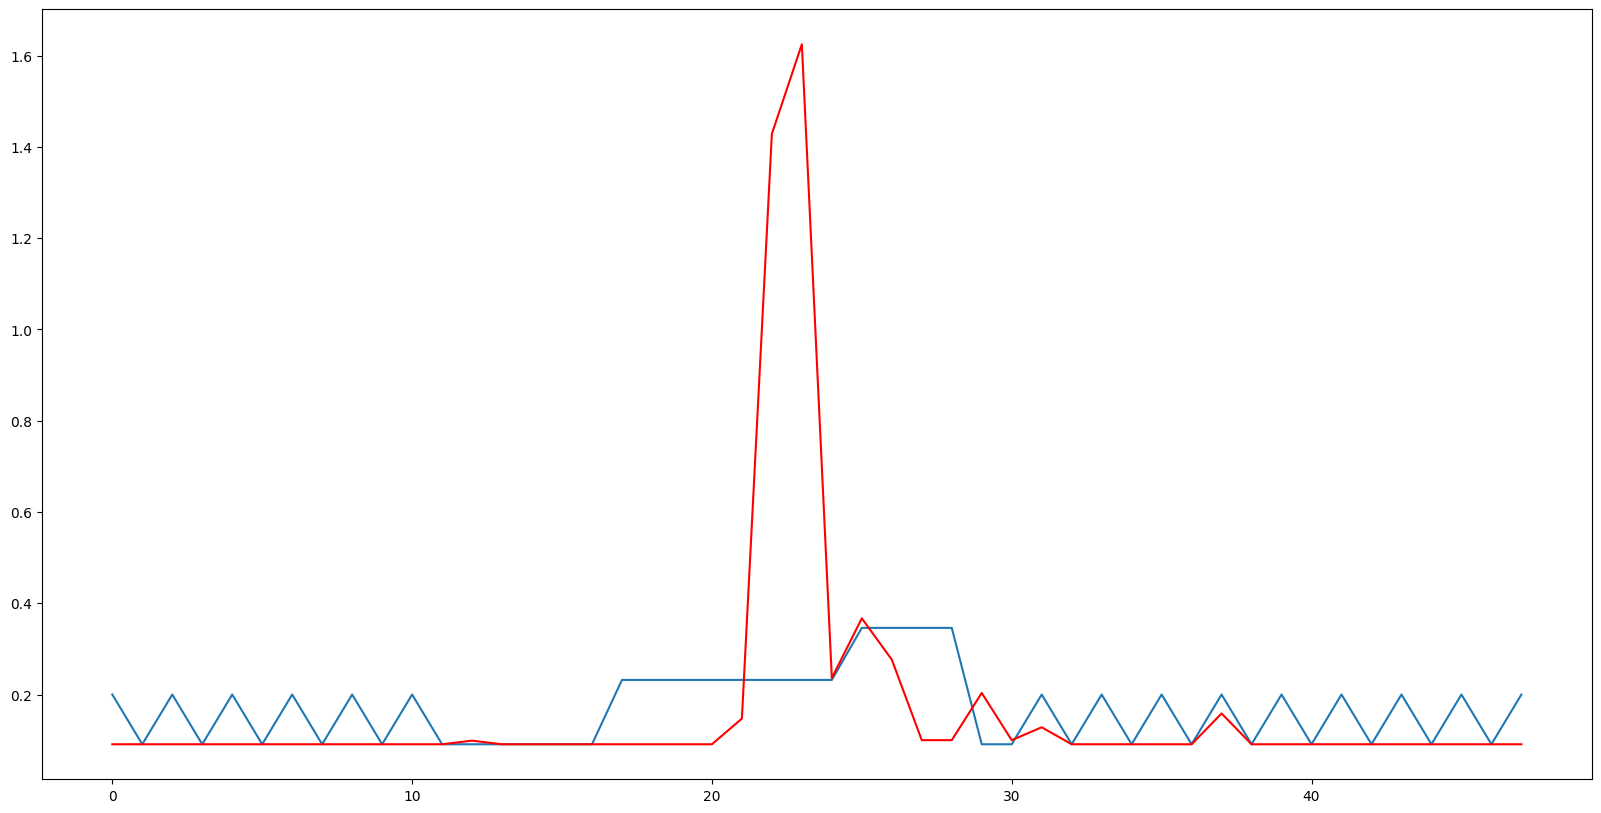

2/2 [==============================] - 0s 27ms/step


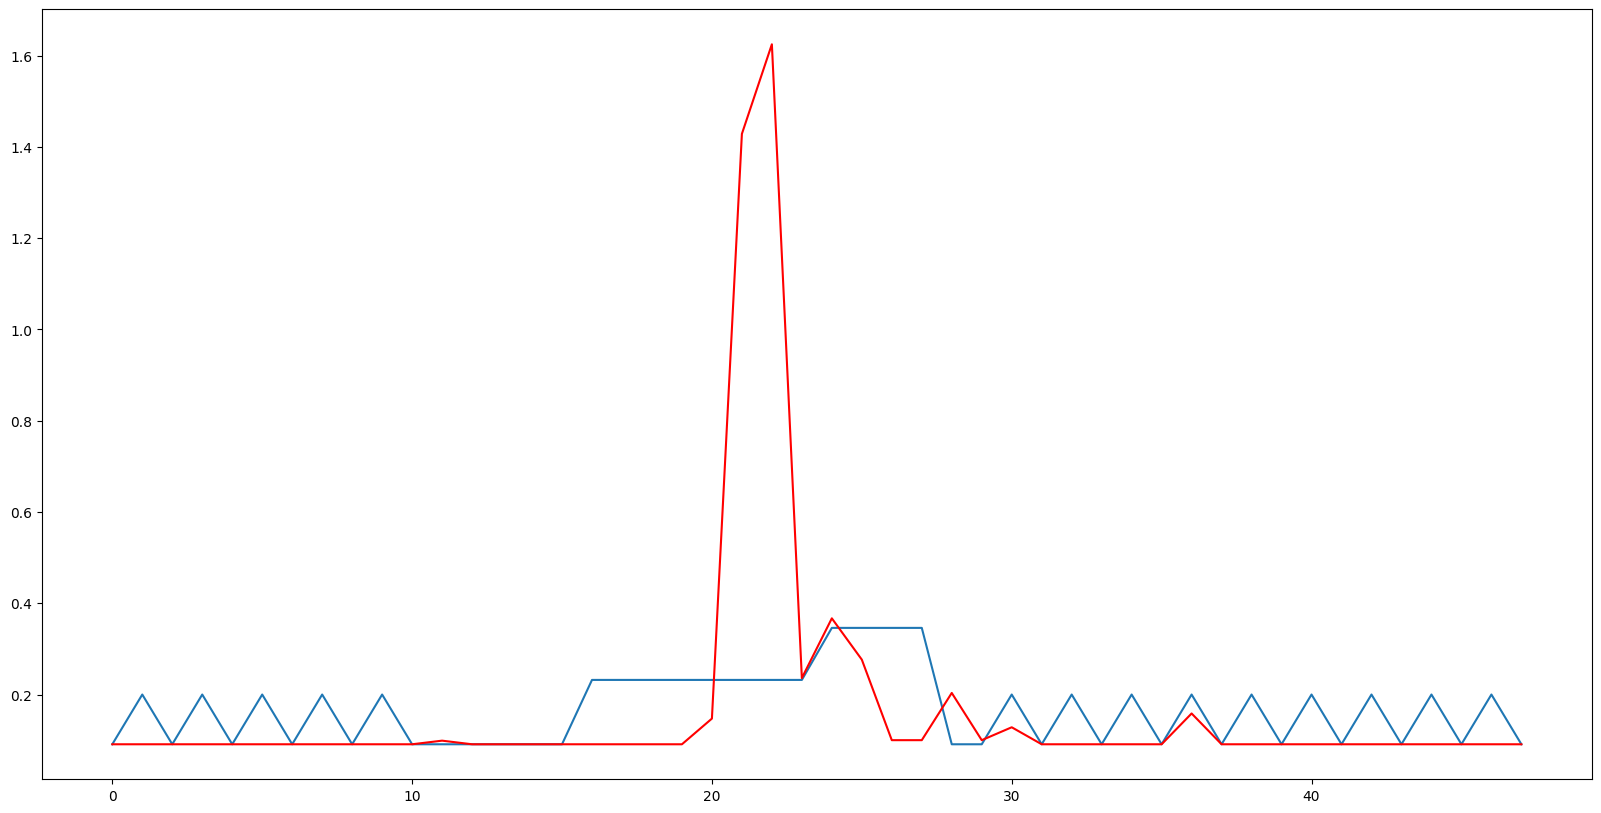

In [118]:
plot_pred(model, Xtest[:48], Ytest[:48])
plot_pred(model, Xtest[1:49], Ytest[1:49])

In [132]:
df_load_val_batches = {'X_test_batch': Xtest, 'Y_test_batches': Ytest, 'X_train': Xtrain, 'Y_train': Ytrain, 'original filtered data': df, 'training_size': training_size,  'scaler_y': scaler}
type(df_load_val_batches)
dump(df_load_val_batches, 'data/cleaned_data/load_model_data.bin')

['data/cleaned_data/load_model_data.bin']

GAN

In [137]:
import tensorflow as tf
from tensorflow.keras import layers

# Generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_shape=(100,), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1, activation='tanh'))

    return model

# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(512, input_shape=(1,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Create GAN
def make_gan(generator, discriminator):
    discriminator.trainable = False
    gan = tf.keras.Sequential([generator, discriminator])
    return gan

# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define discriminator loss function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define generator loss function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Initialize models
generator = make_generator_model()
discriminator = make_discriminator_model()
gan = make_gan(generator, discriminator)
print(gan.summary())
# Define training loop
@tf.function
def train_step(real_data):
    batch_size = tf.shape(real_data)[0]
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train_gan(dataset, epochs, batch_size):
    for epoch in range(epochs):
        for batch in dataset:
            train_step(batch)

        # Display progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} completed")



Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_26 (Sequential)  (None, 1)                 160769    
                                                                 
 sequential_27 (Sequential)  (None, 1)                 132609    
                                                                 
Total params: 293,378
Trainable params: 159,233
Non-trainable params: 134,145
_________________________________________________________________
None


In [146]:
df_1=df['load'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(-1,1))
ts = (df_1 - np.mean(df_1)) / np.std(df_1)
# ts = df_1 

In [143]:
# Set hyperparameters
epochs = 120
batch_size = 512


In [147]:
# Convert to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(ts).shuffle(ts.shape[0]).batch(batch_size)

# Train the GAN model
train_gan(train_dataset, epochs, batch_size)

Epoch 10/120 completed
Epoch 20/120 completed
Epoch 30/120 completed
Epoch 40/120 completed
Epoch 50/120 completed
Epoch 60/120 completed
Epoch 70/120 completed
Epoch 80/120 completed
Epoch 90/120 completed
Epoch 100/120 completed
Epoch 110/120 completed
Epoch 120/120 completed


Generated Samples:

Evaluation Results:
Generated Mean: 502.45294
Generated Std: 0.06513739


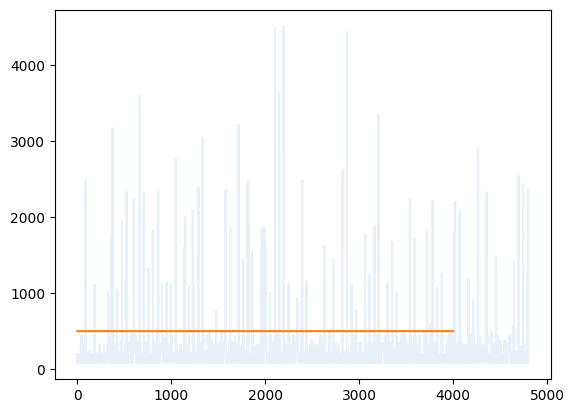

In [148]:
# Generate new time series samples
def generate_samples(generator, num_samples):
    noise = tf.random.normal([num_samples, 100])
    generated_data = generator(noise, training=False)
    return generated_data.numpy()

# Generate and evaluate samples
num_generated_samples = 4000
generated_samples = generate_samples(generator, num_generated_samples)

# Denormalize generated samples
# generated_samples = generated_samples * np.std(df_1) + np.mean(df_1)
generated_samples = generated_samples * np.std(df_1) + np.mean(df_1)

# Evaluate the generated samples (example: calculate mean and standard deviation)
generated_mean = np.mean(generated_samples)
generated_std = np.std(generated_samples)

# Display results
print("Generated Samples:")
plt.plot(ts* np.std(df_1) + np.mean(df_1),alpha=0.1)
plt.plot(generated_samples)

print("\nEvaluation Results:")
print("Generated Mean:", generated_mean)
print("Generated Std:", generated_std)

CNN with GAN

In [115]:
# Generator model
def make_generator_model():
    model = tf.keras.Sequential()

    # Input: [batch_size, 100]
    model.add(layers.Dense(7 * 7 * 128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape to 7x7 feature maps with 128 channels
    model.add(layers.Reshape((7, 7, 128)))

    # Convolutional layers
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Output layer
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Input: [batch_size, 28, 28, 1]
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten output for classification
    model.add(layers.Flatten())

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Initialize models
generator = make_generator_model()
discriminator = make_discriminator_model()
gan = make_gan(generator, discriminator)
print(gan.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 28, 28, 1)         909472    
                                                                 
 sequential_18 (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 1,122,337
Trainable params: 896,736
Non-trainable params: 225,601
_________________________________________________________________
None


In [116]:
# Normalize data to [-1, 1]
df_1=df['load'].values.reshape(-1,1)
data = (df_1 - np.mean(df_1)) / np.std(df_1)
num_samples = data.shape[0]

# Convert to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(num_samples).batch(batch_size)

# ... training loop ...
# Train the GAN model
train_gan(train_dataset, epochs, batch_size)

# Generate new time series samples
def generate_samples(generator, num_samples):
    noise = tf.random.normal([num_samples, 100])
    generated_data = generator(noise, training=False)
    return generated_data.numpy()

# Generate and evaluate samples
num_generated_samples = 4000
generated_samples = generate_samples(generator, num_generated_samples)

# Denormalize generated samples
generated_samples = generated_samples * np.std(data) + np.mean(data)

# Evaluate the generated samples (example: calculate mean and standard deviation)
generated_mean = np.mean(generated_samples)
generated_std = np.std(generated_samples)

# Display results
print("Generated Samples:")

plt.plot(generated_samples)
plt.plot(df_1)
print("\nEvaluation Results:")
print("Generated Mean:", generated_mean)
print("Generated Std:", generated_std)

ValueError: in user code:

    File "C:\Users\mukul\AppData\Local\Temp\ipykernel_19732\2036082725.py", line 71, in train_step  *
        real_output = discriminator(real_data, training=True)
    File "d:\mukul\anaconda3\envs\SOML\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "d:\mukul\anaconda3\envs\SOML\lib\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_18" "                 f"(type Sequential).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (512, 1)
    
    Call arguments received by layer "sequential_18" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(512, 1), dtype=float64)
      • training=True
      • mask=None
